## Function Calling

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, LSTM,MaxPooling1D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score,mean_squared_error
from sklearn.metrics import mean_squared_error as mse

## Loading Datasheet

In [3]:
# Load Dataset as "DF"
df = pd.read_csv('/Users/choon/OneDrive/Desktop/SIT FYP/KCL FYP/Testings/Degradation/Dataset3.4.csv')

# Create a new column named "Time_Stamp" by formating the old "timestamp"
df['Time_Stamp'] = pd.to_datetime(df['timestamp'],format='%d/%m/%Y %H:%M')

# Drop the old timestamp and set the new "Time_Stamp" As the index 
df.drop(columns=['timestamp',], inplace=True)
df.set_index('Time_Stamp', inplace=True)

In [4]:
# Showing the top 26 rows of your dataset
df[:26]

,Active_Power,Pyranometer_1
Time_Stamp,,
2016-04-01 23:45:00,0.0,0.0
2016-04-01 23:50:00,0.0,0.0
2016-04-01 23:55:00,0.0,0.0
2016-04-02 00:00:00,0.0,0.0
2016-04-02 00:05:00,0.0,0.0
2016-04-02 00:10:00,0.0,0.0
2016-04-02 00:15:00,0.0,0.0
2016-04-02 00:20:00,0.0,0.0
2016-04-02 00:25:00,0.0,0.0


## Scaling dataset

In [5]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Define sequence length and features
sequence_length = 24  # Number of time steps in each sequence
num_features = len(df.columns)

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_data) - sequence_length):
    seq = scaled_data[i:i+sequence_length]
    label = scaled_data[i+sequence_length][0]  # 'Active_Power' column index
    sequences.append(seq)
    labels.append(label)

sequences = np.array(sequences)
labels = np.array(labels)

#Sequence = the variable affecting the prediction (Active_Power and Pyranometer_1)
# Label = the variable to predict (Active_Power)

## Splitting of dataset

In [69]:
# Calculate the indices for splitting
# 70% training, 20% validation, 10% testing

train_size = int(0.7 * len(sequences))
validation_size = int(0.2 * len(sequences))
test_size = len(sequences) - train_size - validation_size

# Split the sequences and labels accordingly
train_x, validation_x, test_x = sequences[:train_size], sequences[train_size:train_size+validation_size], sequences[train_size+validation_size:]
train_y, validation_y, test_y = labels[:train_size], labels[train_size:train_size+validation_size], labels[train_size+validation_size:]

# Print the shapes of the splits to verify
print("Train X shape:", train_x.shape)
print("Train Y shape:", train_y.shape)
print("Validation X shape:", validation_x.shape)
print("Validation Y shape:", validation_y.shape)
print("Test X shape:", test_x.shape)
print("Test Y shape:", test_y.shape)

Train X shape: (367675, 24, 2)
Train Y shape: (367675,)
Validation X shape: (105050, 24, 2)
Validation Y shape: (105050,)
Test X shape: (52526, 24, 2)
Test Y shape: (52526,)


## Building and Tuning an LSTM Model with Keras and Keras Tuner

In [71]:
import keras_tuner as kt
from tensorflow import keras
from keras.layers import LSTM,RepeatVector,Dropout,TimeDistributed,Dense


def build_model(hp):
    model = keras.Sequential()

    # Add an LSTM layer
    model.add(LSTM(units=hp.Int('lstm_units', min_value=10, max_value=150, step=10),
                       return_sequences=True,
                       input_shape=(train_x.shape[1], train_x.shape[2])))

  # Add an LSTM layer
    model.add(LSTM(units=hp.Int('lstm_units', min_value=10, max_value=150, step=10)))


    # Add a dropout layer
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)))

    # Add dense 1st layer
    model.add(Dense(units=hp.Int('dense_units_1' , min_value=10, max_value=150, step=10),
                               activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_rate_1' , min_value=0.0, max_value=0.5, step=0.1)))

    # Add dense 2nd layer
    model.add(Dense(units=hp.Int('dense_units_2' , min_value=10, max_value=100, step=10),
                             activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_rate_2' , min_value=0.0, max_value=0.5, step=0.1)))

    # Add the output layer
    model.add(Dense(1, activation='linear'))

    # Compile the model
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3,1e-4])),
                  loss='mse',
                  metrics=['mae'])

    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    directory='mydir',
    project_name='lstm_Aus_5Year')

# project_name needs to be changed to a different name for a new LSTM model 

tuner.search_space_summary()

Search space summary
Default search space size: 7
lstm_units (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 150, 'step': 10, 'sampling': 'linear'}
dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
dense_units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 150, 'step': 10, 'sampling': 'linear'}
dropout_rate_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
dense_units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 10, 'sampling': 'linear'}
dropout_rate_2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


## # Implementing Callbacks for Learning Rate Reduction and Early Stopping in Model Training

In [72]:
from keras.callbacks import ReduceLROnPlateau
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)
# Reduce learning rate by a factor of 0.5 when the validation loss does not improve for 5 epochs.
# The minimum learning rate is 0.0001.

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)

tuner.search(train_x, train_y,
             epochs=80,
             validation_data=(test_x, test_y),callbacks=[reduce_lr,early_stopping],batch_size=100)

Trial 20 Complete [01h 21m 43s]
val_loss: 0.001651342143304646

Best val_loss So Far: 0.0011787050170823932
Total elapsed time: 22h 28m 10s


## # Retrieving the Best Model and Hyperparameters from Keras Tuner

In [74]:
lstm=tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=10)[0]
print(best_hyperparameters.values)

{'lstm_units': 90, 'dropout_rate': 0.2, 'dense_units_1': 130, 'dropout_rate_1': 0.2, 'dense_units_2': 90, 'dropout_rate_2': 0.30000000000000004, 'learning_rate': 0.01}


## Making Predictions and Comparing with Actual Values Using LSTM for validation Model

In [75]:
import numpy as np
import pandas as pd

# Assuming train_x is your input data and y_train1 is your actual output data
train_predictions = lstm.predict(train_x).flatten()

# Ensure y_train1 is a 1-dimensional array
train_y = np.array(train_y).flatten()

# Create DataFrame with predictions and actual values
train_results = pd.DataFrame(data={'Train Predictions': train_predictions, 'Actuals': train_y})

# Display the first 30 rows
print(train_results[:100])

11490/11490 [==============================] - 357s 31ms/step
    Train Predictions   Actuals
0            0.001868  0.000000
1            0.001868  0.000000
2            0.001868  0.000000
3            0.001868  0.000000
4            0.001868  0.000000
..                ...       ...
95           0.479095  0.493693
96           0.458406  0.510474
97           0.498252  0.527412
98           0.536761  0.539905
99           0.566696  0.552714

[100 rows x 2 columns]


## Plotting results for predicted vs actual values for training 

Mean Squared Error for Training Predictions is: 0.0013780081554025667
Root Mean Squared Error for Training Predictions is: 0.03712153223403591
Mean aboslute Error for Training Predictions is: 0.01294275929834444
R2 Training Predictions is: 0.9814064748576157


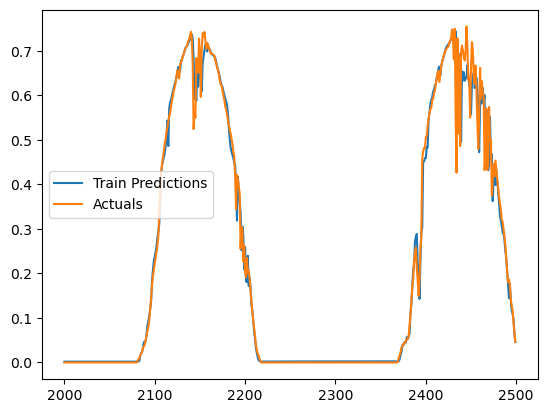

In [77]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][2000:2500], label='Train Predictions') 
plt.plot(train_results['Actuals'][2000:2500], label='Actuals')
plt.legend()

training_mse = mse(train_predictions, train_y)
training_mae = mean_absolute_error(train_y, train_predictions)

# Print the MSE
print('Root Mean Squared Error for Training Predictions is:', training_rmse)

## Making Predictions and Comparing with Actual Values Using LSTM for Validation Data

In [78]:
# Assuming train_x is your input data and y_train1 is your actual output data
val_predictions = lstm.predict(validation_x).flatten()

# Ensure y_train1 is a 1-dimensional array
val_y = np.array(validation_y).flatten()

# Create DataFrame with predictions and actual values
val_results = pd.DataFrame(data={'Validation Predictions': val_predictions, 'Actuals': validation_y})

# Display the first 30 rows
print(val_results[:100])

3283/3283 [==============================] - 110s 34ms/step
    Validation Predictions   Actuals
0                 0.001868  0.000000
1                 0.001868  0.000000
2                 0.001868  0.000000
3                 0.001868  0.000000
4                 0.001868  0.000000
..                     ...       ...
95                0.396244  0.406102
96                0.398817  0.420013
97                0.424355  0.437416
98                0.436454  0.450054
99                0.445635  0.469744

[100 rows x 2 columns]


## Plotting results for predicted vs actual values for Validation 

Mean Squared Error for Validation Predictions is: 0.0008575564105920671
Root Mean Squared Error for Validation Predictions is: 0.029284064106473797
Mean aboslute Error for Validation Predictions is: 0.009048230805208696
R2 Validation Predictions is: 0.9854472452297149


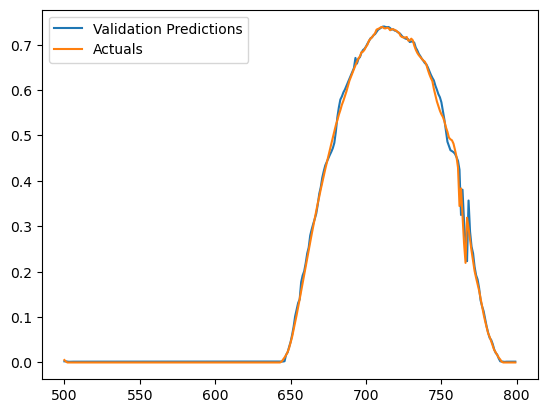

In [79]:
plt.plot(val_results['Validation Predictions'][500:800], label='Validation Predictions')
plt.plot(val_results['Actuals'][500:800], label='Actuals')
plt.legend()

val_mse = mse(val_predictions, validation_y)
val_mae = mean_absolute_error(validation_y,val_predictions)
val_rmse = np.sqrt(val_mse)
val_r2 = r2_score(validation_y, val_predictions)



# Print the MSE
print('Mean Squared Error for Validation Predictions is:', val_mse)
print('Root Mean Squared Error for Validation Predictions is:', val_rmse)
print('Mean aboslute Error for Validation Predictions is:', val_mae)
print('R2 Validation Predictions is:', val_r2)

## Making Predictions and Comparing with Actual Values Using LSTM for Testing Data

In [80]:
# Assuming train_x is your input data and y_train1 is your actual output data
test_predictions = lstm.predict(test_x).flatten()

# Ensure y_train1 is a 1-dimensional array
test_y = np.array(test_y).flatten()

# Create DataFrame with predictions and actual values
test_results = pd.DataFrame(data={'Test Predictions': test_predictions, 'Actuals': test_y})

# Display the first 30 rows
print(test_results[:100])

1642/1642 [==============================] - 54s 33ms/step
    Test Predictions  Actuals
0           0.001868      0.0
1           0.001868      0.0
2           0.001868      0.0
3           0.001868      0.0
4           0.001868      0.0
..               ...      ...
95          0.001868      0.0
96          0.001868      0.0
97          0.001868      0.0
98          0.001868      0.0
99          0.001868      0.0

[100 rows x 2 columns]


## Plotting results for predicted vs actual values for Validation 

Mean Squared Error for Testing Predictions is: 0.0011787052829702323
Root Mean Squared Error for Testing Predictions is: 0.03433227756747624
Mean aboslute Error for Testing Predictions is: 0.010325773596831709
R2 Testing Predictions is: 0.9764739925629033


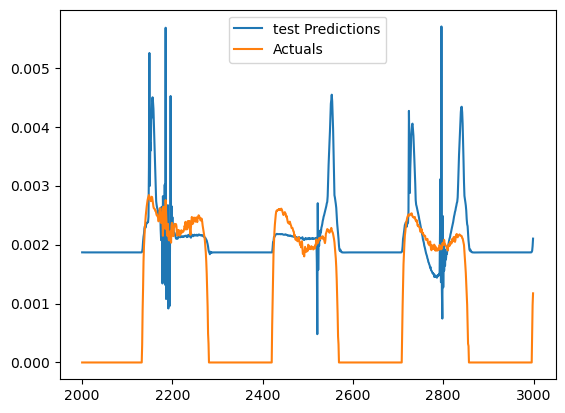

In [81]:
plt.plot(test_results['Test Predictions'][2000:3000], label='test Predictions') 
plt.plot(test_results['Actuals'][2000:3000], label='Actuals')
plt.legend()

test_mse = mse(test_predictions, test_y)
test_mae = mean_absolute_error(test_y, test_predictions)

# Print the MSE
print('Root Mean Squared Error for Testing Predictions is:', test_rmse)

In [82]:
# Comparing the difference of errors for training, validation and testing

print('Root Mean Squared Error for Training Predictions is:', training_rmse)
print('Root Mean Squared Error for Validation Predictions is:', val_rmse)
print('Root Mean Squared Error for Testing Predictions is:', test_rmse)

Mean Squared Error for Training Predictions is: 0.0013780081554025667
Mean Squared Error for Validation Predictions is: 0.0008575564105920671
Mean Squared Error for Testing Predictions is: 0.0011787052829702323
Root Mean Squared Error for Training Predictions is: 0.03712153223403591
Root Mean Squared Error for Validation Predictions is: 0.029284064106473797
Root Mean Squared Error for Testing Predictions is: 0.03433227756747624
Mean aboslute Error for Training Predictions is: 0.01294275929834444
Mean aboslute Error for Validation Predictions is: 0.009048230805208696
Mean aboslute Error for Testing Predictions is: 0.010325773596831709
R2 Training Predictions is: 0.9814064748576157
R2 Validation Predictions is: 0.9854472452297149
R2 Testing Predictions is: 0.9764739925629033


In [83]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

# Load the new dataset
df_new = pd.read_csv('/Users/choon/OneDrive/Desktop/SIT FYP/KCL FYP/Testings/Degradation/Dataset3.4.1.csv')
df_new['Time_Stamp'] = pd.to_datetime(df_new['timestamp'], format='%d/%m/%Y %H:%M')
df_new.drop(columns=['timestamp'], inplace=True)
df_new.set_index('Time_Stamp', inplace=True)


# Normalize the new data
scaled_data_new = scaler.transform(df_new)  # Use the same scaler as before

# Define sequence length and features
sequence_length = 24  # Number of time steps in each sequence
num_features = len(df_new.columns)

# Create sequences and corresponding labels
sequences_new = []
labels_new = []
for i in range(len(scaled_data_new) - sequence_length):
    seq = scaled_data_new[i:i+sequence_length]
    label = scaled_data_new[i+sequence_length][0]  # Assuming 'Active_Power' is the first column
    sequences_new.append(seq)
    labels_new.append(label)

sequences_new = np.array(sequences_new)
labels_new = np.array(labels_new)

# Split into training (first 3 years) and testing (next 2 years)
# Assuming the data is ordered by time
test_x_new = sequences_new
test_y_new = labels_new

# Print the shapes of the splits to verify
print("Test X shape:", test_x_new.shape)
print("Test Y shape:", test_y_new.shape)

# Load the existing model
lstm = tuner.get_best_models(num_models=1)[0]

# Optionally, further train the model on the new training data
# lstm.fit(train_x_new, train_y_new, epochs=80, validation_data=(test_x_new, test_y_new), batch_size=100, callbacks=[reduce_lr, early_stopping])

# Make predictions
predictions = lstm.predict(test_x_new)

print(predictions)


Test X shape: (209238, 24, 2)
Test Y shape: (209238,)
6539/6539 [==============================] - 240s 36ms/step
[[0.00186777]
 [0.00186777]
 [0.00186777]
 ...
 [0.00186777]
 [0.00186777]
 [0.00186777]]


In [84]:
# Assuming train_x is your input data and y_train1 is your actual output data
test_predictions = lstm.predict(test_x_new).flatten()

# Ensure y_train1 is a 1-dimensional array
test_y_new = np.array(test_y_new).flatten()

# Create DataFrame with predictions and actual values
test_results_new = pd.DataFrame(data={'Test Predictions': test_predictions, 'Actuals': test_y_new})

# Display the first 30 rows
print(test_results_new[:100])

6539/6539 [==============================] - 230s 35ms/step
    Test Predictions   Actuals
0           0.001868  0.000000
1           0.001868  0.000000
2           0.001868  0.000000
3           0.001868  0.000000
4           0.001868  0.000000
..               ...       ...
95          0.560387  0.546286
96          0.578136  0.558040
97          0.587016  0.570334
98          0.596297  0.583269
99          0.605898  0.595032

[100 rows x 2 columns]


Root Mean Squared Error for Testing Predictions is: 0.040260300933380455


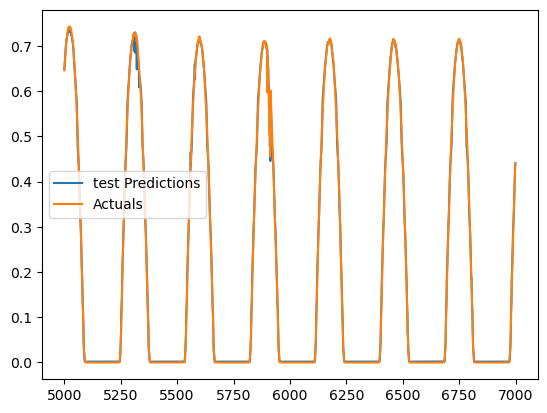

In [85]:
plt.plot(test_results_new['Test Predictions'][5000:7000], label='test Predictions') 
plt.plot(test_results_new['Actuals'][5000:7000], label='Actuals')
plt.legend()

test_mse_new = mse(test_predictions, test_y_new)
test_rmse_new = np.sqrt(test_mse_new)

# Print the MSE
print('Root Mean Squared Error for Testing Predictions is:', test_rmse_new)